# Example PSI Model Synthesis Notebook

 Tom Schad | National Solar Observatory

----

**About this notebook:**

- This notebook does an example synthesis of the global corona using a Predictive Sciences MHD model. 
- Most of the details for synthesis of any line at any time can be gleaned from this example; however, it is not currently build as its own class.  A module 'psi.py' is available in the examples directory to interact with the PSI models.  At some point, these synthesis routines may evolve into its own package. 

**A note on pycelp speed and accuracy:**
- This example demonstrates the forward synthesis of the Fe XIII 1074.6 nm emission line, and it uses an atomic model consisting of 50 levels. Schad & Dima (2020) discuss the relative accuracy of using models of various size, as well as the fact that computational cost increases dramatically with the number of levels included.  
- Some authors have built reduced size atomic models that attempt to emulate the behavior of a larger model atom.  While this can increase the speed of the computations, one should be careful that such models are accurate enough for your particular application.  The pyCELP ion class has been build in such a way that parallel processing is easily accomplished with the standard python tools.  
- Alternatively one could build databases in the manner of Schad & Dima (2020) to accelerate calculations over multiple datasets. 

----

In [1]:
import os

## The multiprocessing calls of pycelp should be used while restricting threads to avoid oversubscribing resources
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
os.environ['NUMEXPR_MAX_THREADS'] = '1'

import numpy as np
import multiprocessing
import tqdm
from tqdm.auto import trange

## Chianti database location 
os.environ["XUVTOP"] = '/usr/local/ssw/packages/chianti/dbase/'
import pycelp 
import pycelp.allenSolRad as allen
import psi

## Plotting tools and settings 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import PowerNorm,SymLogNorm,LogNorm
plt.rcParams["image.origin"]='lower'   ## have to worry about flips? 
plt.rcParams["image.interpolation"]='nearest'
try: 
    plt.rcParams["font.family"] = 'Arial'
except: 
    print(' Arial font not available - using default')
plt.rcParams.update({
    "font.size": 10,  # Default font size for all text
    "axes.labelsize": 10,  # Font size for x and y labels
    "xtick.labelsize": 10,  # Font size for x-axis ticks
    "ytick.labelsize": 10,  # Font size for y-axis ticks
    "legend.fontsize": 10  # Font size for legends
})

from scipy.interpolate import RegularGridInterpolator as rgi
from scipy.interpolate import interp1d,griddata

## Astropy and Sunpy 
from astropy.coordinates import SkyCoord,EarthLocation, AltAz
from astropy.time  import Time,TimeDelta
from astropy import units as u
import sunpy
import sunpy.map
from sunpy.coordinates import frames,sun
import sunpy.sun.constants as constants

haleakala = EarthLocation(lat=20.706760*u.deg,
            lon=-(156.256262)*u.deg,
            height=3067.*u.m)

def euler_ry(alpha):
    '''Euler rotation matrix about y axis '''
    ry = np.array([[ np.cos(alpha), 0., np.sin(alpha)],
                   [            0., 1., 0.],
                   [-np.sin(alpha), 0., np.cos(alpha)]])
    return ry

def euler_rz(alpha):
    '''Euler rotation matrix about z axis '''
    rz = np.array([[ np.cos(alpha), -np.sin(alpha), 0.],
                   [ np.sin(alpha),  np.cos(alpha), 0.],
                   [            0.,             0., 1.]])
    return rz

## Create an instance of the psi.Model class to load and interact with PSI coronal model data

- Models used here were downloaded using this website from [Predictive Sciences](https://www.predsci.com/hmi/data_access.php), or alternatively [here](https://www.predsci.com/data/runs/).
- Here we use the date of the US total solar eclipse (21 Aug 2017) using the med-cor-thermo2 model for this demonstration. 

In [2]:
## https://www.predsci.com/data/runs/cr2194-medium/hmi_mast_mas_std_0201/
## carrington rotation 2194
modelName = 'cr2194_medium___hmi_mast_mas_std_0201'
corona = psi.Model('/data/tschad/psiModels/cr2194-medium/hmi_mast_mas_std_0201/corona/')

In [3]:
## return the instance name for some basic information on the class
corona

psi Model class
    ---------------------
    Data Directory Names: /data/tschad/psiModels/cr2194-medium/hmi_mast_mas_std_0201/corona/
    Number of phi samples: 181
    Number of theta samples: 100
    Number of radial samples: 150
    Data shape: (181, 100, 150)
    
    Variables: 
    thetas -- Spherical polar angle coordinates [rad]
    phis   -- Spherical azimuthal angle coordinates [rad] (same as lons)
    rs   -- Radial coordinates [solar radii units]
    lons -- Longitudes [rad]
    lats -- Latitudes [rad]
    temp -- temperature [K]
    ne -- electron density [cm^-3]
    bx,by,bz  -- Cartesian components of magnetic field [G]
    vx,vy,vz  -- Cartesian components of velocity field [km/s]
    bmag      -- total magnetic field intensity [B]
    thetaBlocal -- location inclination of magnetic field in solar frame [rad]
    

## Get Limb Locations for DKIST (or other observatory) for the time to be synthesized 

In [4]:
synth_time = Time('2017-08-21T12:00:00.000')
observerDKIST =SkyCoord(haleakala.get_itrs(synth_time))
ff = frames.HeliographicCarrington(observer=observerDKIST)
rr = sunpy.coordinates.utils.get_limb_coordinates(observerDKIST)

In [5]:
print("Stonyhurst DKIST Coordinates") 
dkist_stonyhurst = observerDKIST.transform_to(frames.HeliographicStonyhurst)
print(dkist_stonyhurst)
dkist_carrington = observerDKIST.transform_to(ff)
print(dkist_carrington)

Stonyhurst DKIST Coordinates
<SkyCoord (HeliographicStonyhurst: obstime=2017-08-21T12:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.0012399, 6.92083084, 1.5133709e+11)>
<SkyCoord (HeliographicCarrington: obstime=2017-08-21T12:00:00.000, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2017-08-21T12:00:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (0.0012399, 6.92083084, 1.5133709e+11)>): (lon, lat, radius) in (deg, deg, m)
    (293.57759363, 6.92083084, 1.5133709e+11)>


In [6]:
from tqdm.auto import trange
latlon = np.zeros((2,len(rr)))
for n in trange(len(rr)):
    coord = np.copy(rr[n])
    lc = coord.transform_to(ff)
    latlon[0,n] = lc.lat.rad
    latlon[1,n] = lc.lon.rad

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
sortlon = np.argsort(latlon[1,:])
latlon[0,:]= latlon[0,:][sortlon]
latlon[1,:]= latlon[1,:][sortlon]

## Plot magnetic field maps, limb and target coordinates

In [8]:
corona.br.shape,corona.lons.shape,corona.lats.shape

((181, 100, 150), (181,), (100,))

(-1.5973340272903442, 1.5973340272903442)


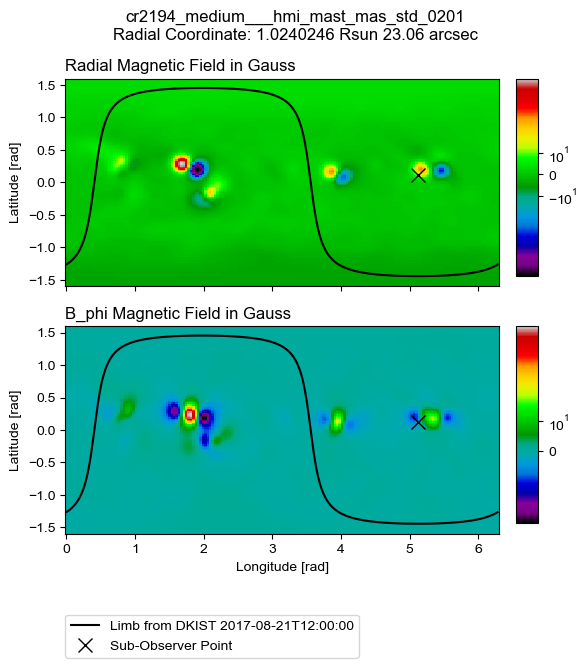

In [9]:
fig,ax = plt.subplots(2,1,figsize = (6,7),sharex=True,sharey=True)
ax = ax.flatten()
kk = 35

ax[0].pcolormesh(corona.lons,corona.lats,corona.br[:,:,kk].T,cmap = 'nipy_spectral',norm = SymLogNorm(40))
ax[1].pcolormesh(corona.lons,corona.lats,corona.bp[:,:,kk].T,cmap = 'nipy_spectral',norm = SymLogNorm(40))

for axi in ax: 
    axi.plot(latlon[1,:],latlon[0,:],'-',color = 'black',label = f'Limb from DKIST {observerDKIST.obstime.isot[0:19]}')
    axi.plot(dkist_carrington.lon.rad,dkist_carrington.lat.rad,'x',markersize = 10,color = 'black',label = 'Sub-Observer Point')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.collections[0],ax=axi,cax=cax) 
    
ax[1].legend(ncol = 1,loc = (0.,-0.6),fontsize =10)

fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]) + ' Rsun ' + str(np.round((corona.rs[kk]-1)*960.,2)) + ' arcsec')

ax[0].set_title('Radial Magnetic Field in Gauss',loc = 'left')
ax[1].set_title('B_phi Magnetic Field in Gauss',loc = 'left')
ax[0].set_ylabel('Latitude [rad]')
ax[1].set_ylabel('Latitude [rad]')
ax[1].set_xlabel('Longitude [rad]')
print(ax[0].get_ylim())
fig.tight_layout()

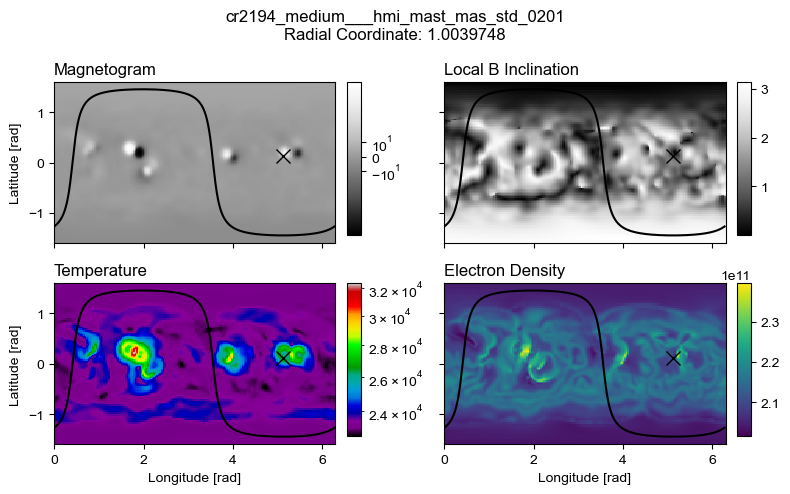

In [10]:
kk = 5
fig,ax = plt.subplots(2,2,figsize = (8,5),sharex=True,sharey=True)
ax = ax.flatten()
ax[0].pcolormesh(corona.lons,corona.lats,corona.br[:,:,kk].T,cmap = 'Greys_r',norm = SymLogNorm(40))
ax[1].pcolormesh(corona.lons,corona.lats,corona.thetaBlocal[:,:,kk].T,cmap = 'Greys_r')
ax[2].pcolormesh(corona.lons,corona.lats,corona.temp[:,:,kk].T,cmap = 'nipy_spectral',norm = LogNorm())
ax[3].pcolormesh(corona.lons,corona.lats,corona.ne[:,:,kk].T,cmap = 'viridis')

for axi in ax: 
    axi.plot(latlon[1,:],latlon[0,:],'-',color = 'black',label = f'Limb from DKIST {observerDKIST.obstime.isot[0:19]}')
    axi.plot(dkist_carrington.lon.rad,dkist_carrington.lat.rad,'x',markersize = 10,color = 'black',label = 'Sub-Observer Point')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.collections[0],ax=axi,cax=cax)  # axi.get_images()[0],ax=axi,cax=cax)

labels = 'Magnetogram','Local B Inclination','Temperature','Electron Density'
for n in range(4): ax[n].set_title(labels[n],loc = 'left')
fig.suptitle(modelName + '\nRadial Coordinate: ' + str(corona.rs[kk]))

ax[0].set_ylabel('Latitude [rad]')
ax[2].set_ylabel('Latitude [rad]')
ax[2].set_xlabel('Longitude [rad]')
ax[3].set_xlabel('Longitude [rad]')

fig.tight_layout()

## Compare to GONG and HMI synoptic maps

This is the GONG 2194_000 synoptic map 

<img src="https://gong.nso.edu/data/magmap/QR/mqj/201708/mrmqj170830/mrmqj170830t0205c2194_000.jpg" width = 500/>

This is the HMI synoptic map 

<img src="https://jsoc1.stanford.edu/data/hmi/synoptic/hmi.Synoptic_Mr.2194.png" width = 1000/>

## Show some radial variations of the state variables

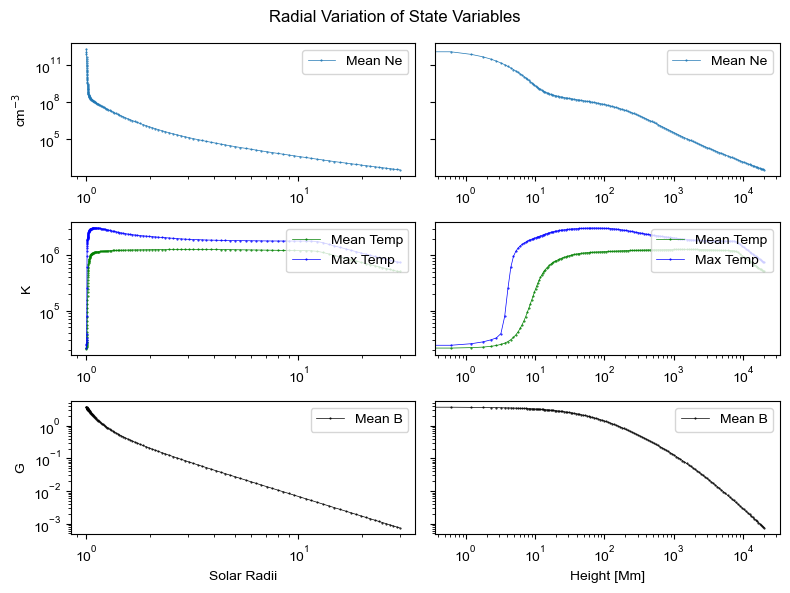

In [11]:
fig,ax = plt.subplots(3,2,figsize = (8,6),sharey='row') 
#ax = ax.flatten()
ax[0][0].plot(corona.rs,np.mean(corona.ne,axis=(0,1)),'.-',label = 'Mean Ne',markersize=1, lw=0.5) 
ax[0][0].set_yscale('log')
ax[1][0].plot(corona.rs,np.mean(corona.temp,axis=(0,1)),'g.-',label = 'Mean Temp',markersize=1, lw=0.5) 
ax[1][0].plot(corona.rs,np.max(corona.temp,axis=(0,1)),'b.-',label = 'Max Temp',markersize=1, lw=0.5) 
ax[1][0].set_yscale('log')
ax[2][0].plot(corona.rs,np.mean(corona.bmag,axis=(0,1)),'k.-',label = 'Mean B',markersize = 1, lw=0.5) 
ax[2][0].set_yscale('log')

yl = r'cm$^{-3}$','K','G',
for n in range(3): ax[n][0].set_ylabel(yl[n])

ax[0][1].plot((corona.rs-1)*constants.radius/1e6,np.mean(corona.ne,axis=(0,1)),'.-',label = 'Mean Ne',markersize=1, lw=0.5) 
ax[1][1].plot((corona.rs-1)*constants.radius/1e6,np.mean(corona.temp,axis=(0,1)),'g.-',label = 'Mean Temp',markersize=1, lw=0.5) 
ax[1][1].plot((corona.rs-1)*constants.radius/1e6,np.max(corona.temp,axis=(0,1)),'b.-',label = 'Max Temp',markersize=1, lw=0.5) 
ax[2][1].plot((corona.rs-1)*constants.radius/1e6,np.mean(corona.bmag,axis=(0,1)),'k.-',label = 'Mean B',markersize = 1, lw=0.5) 
ax[2][1].set_xlabel('Height [Mm]')

for axi in ax.flatten(): 
    axi.set_xscale('log')
    axi.set_yscale('log')
    axi.legend(loc = 'upper right')
ax[2][0].set_xlabel('Solar Radii')
fig.suptitle("Radial Variation of State Variables")
fig.tight_layout()

## Show Radial Samples

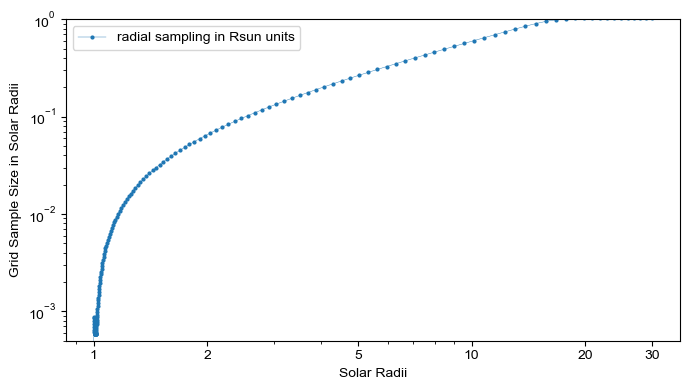

In [12]:
fig,ax = plt.subplots(1,1,figsize = (7,4))
ax.plot(corona.rs,(corona.rs-np.roll(corona.rs,1)),'.-',lw = 0.3,markersize = 4,label = 'radial sampling in Rsun units')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1,2,5,10,20,30])
ax.xaxis.set_ticklabels(['1','2','5','10','20','30'])
ax.set_ylim(0.0005,1)
ax.set_xlabel('Solar Radii')
ax.set_ylabel('Grid Sample Size in Solar Radii')
fig.tight_layout()

## Initialize the pyCELP model of the line or lines to be synthesized

- Here we start with Fe XIII 1074 nm and keep the model fairly "small" at 50 levels.  The errors incurred by using reduced numbers of atomic levels is addressed in [Schad & Dima (2020)](https://rdcu.be/b5J2X) 


In [13]:
abundFile = '/usr/local/ssw/packages/chianti/dbase/abundance/sun_coronal_2021_chianti.abund'
fe13 = pycelp.Ion('fe_13',nlevels = 50,abundFile=abundFile)
fe13_ln1 = fe13.get_emissionLine(10747.)
fe13_ln2 = fe13.get_emissionLine(10798.)

 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.elvlc
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.wgfa
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.scups
 reading:  /usr/local/ssw/packages/chianti/dbase/fe/fe_13/fe_13.psplups
 using abundances from: /usr/local/ssw/packages/chianti/dbase/abundance/sun_coronal_2021_chianti.abund
 reading:  /usr/local/ssw/packages/chianti/dbase/abundance/sun_coronal_2021_chianti.abund
 testing default file: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 reading:  /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq
 setting up electron collision rate factors
 setting up proton  collision rate factors
 setting up non-dipole radiative rate factors
 getting non-dipole rate factors
 setting up dipole radiative rate factors


In [14]:
fe13

pyCELP Ion class
    ---------------------
    Ion Name: fe_13
    Number of energy levels included: 50
    Number of SEE equations: 142
    Number of Radiative Transitions: 366
    Ionization Equilbrium Filename: /usr/local/ssw/packages/chianti/dbase/ioneq/chianti.ioneq

In [15]:
edens = 1e9
etemp = 1e7
ht = 0.1
thetab = 10.
%timeit fe13.calc_rho_sym(edens,etemp,ht, thetab)

636 μs ± 157 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Calculate the statistical equilibrium for every cell

- Here the statistical equilibrium is calculated for the Ion for each cell in the PSI model and the results of the upper level populations, alignments, and total ion population are stored in arrays. 
- The advantage of doing it this way is that that statistical equilibrium does not change with viewing angle, and so if you want to synthesis the polarized intensities at a different viewing angle, you do not have to recalculate the statistical equilibrium. 

In [16]:
nlons,nlats,nr = corona.bx.shape

In [17]:
def work(argin): 
    
    ii,jj,kk = argin 
    
    edens = corona.ne[ii,jj,kk]
    etemp = corona.temp[ii,jj,kk]
    ht = (corona.rs[kk]-1).clip(1.e-8)
    thetab = np.rad2deg(corona.thetaBlocal[ii,jj,kk])
    
    fe13.calc_rho_sym(edens,etemp,ht, thetab)
    
    ln1 = fe13.get_emissionLine(10747.)
    ln2 = fe13.get_emissionLine(10798.)
    
    return (ii,jj,kk,ln1.C_coeff,ln1.upper_level_alignment, 
                ln2.C_coeff,ln2.upper_level_alignment)

## setup save file for repeat runs of this notebook and to not repeat the 
## statistical equilbrium calculation 

savefn = './fe13_1074_1079_pops.npz'

if not os.path.isfile(savefn):

    ncpus = multiprocessing.cpu_count()-1
    arg_array = []
    for ii in range(0,nlons,1): 
        for jj in range(0,nlats,1): 
            for kk in range(0,nr,1): 
                arg_array.append([ii,jj,kk])

    ccoef_10747 = np.zeros_like(corona.bx)
    align_10747 = np.zeros_like(corona.bx)
    ccoef_10798 = np.zeros_like(corona.bx)
    align_10798 = np.zeros_like(corona.bx)

    p     = multiprocessing.Pool(processes=ncpus) 
    rs    = p.imap(work,arg_array)
    p.close()

    for res in tqdm.tqdm(rs,total = len(arg_array)): 
        ii,jj,kk,r1,a1,r2,a2 = res 
        ccoef_10747[ii,jj,kk] = r1
        align_10747[ii,jj,kk] = a1
        ccoef_10798[ii,jj,kk] = r2
        align_10798[ii,jj,kk] = a2

    np.savez(savefn,ccoef_10747=ccoef_10747,align_10747=align_10747,ccoef_10798=ccoef_10798,align_10798=align_10798)
    
else: 
    
    ## if variables not defined load 
    if "ccoef_10747" not in globals():
        print('loading: ',savefn)
        npzd = np.load(savefn)
        ccoef_10747 = npzd['ccoef_10747']
        align_10747 = npzd['align_10747']
        ccoef_10798 = npzd['ccoef_10798']
        align_10798 = npzd['align_10798']

loading:  ./fe13_1074_1079_pops.npz


## Setup forward synthesis geometry

- Now we start to setup the synthesis geometry by figuring out rays to cast from an observer's position through the model

### Observer's Position

In [18]:
print(f"Observers time for the synthesis is {synth_time.isot}")
crn        = sun.carrington_rotation_number(synth_time)
crt        = sun.carrington_rotation_time(crn)
obsLon     = sun.L0(crt).rad
obsLat     = sun.B0(crt).rad
Obs_Sun_AU = sun.earth_distance(crt).value
rsunarc    = sun.angular_radius(crt).value  ## radius of sun in arcseconds .. later replace with sun ephemeris

print('Carrington Rotation Number:     ',crn)
print('Carrington Rotation Time:       ',crt)
print('Observers Longitude [deg]:      ',np.rad2deg(obsLon))
print('Observers Latitude [deg]:       ',np.rad2deg(obsLat))
print('Observers distance to Sun [AU]: ',Obs_Sun_AU)
print('Apparent solar radius [arcsec]: ',rsunarc)

Observers time for the synthesis is 2017-08-21T12:00:00.000
Carrington Rotation Number:      2194.184510135986
Carrington Rotation Time:        2017-08-21 12:00:00.010
Observers Longitude [deg]:       293.57634954025457
Observers Latitude [deg]:        6.919906588300291
Observers distance to Sun [AU]:  1.0115931095084487
Apparent solar radius [arcsec]:  948.2380793963277


In [19]:
solar_rad_m, au_m = constants.radius.value,constants.astronomical_unit.value

## Observer's position in spherical coordinates in the PSI Carrington Geometry
rObs     = Obs_Sun_AU * (au_m/solar_rad_m)  ## rObs is the radial position of the observer in solar radii
thetaObs = np.pi/2. - obsLat   ## Observers latitude in the PSI model geometry (0 is the NorthPole)
phiObs   = obsLon ## Observers Lon in PSI model geometry  
## cartesian position of Observer in PSI model geometery (units of solar radii)
xObs,yObs,zObs = rObs*np.sin(thetaObs)*np.cos(phiObs),rObs*np.sin(thetaObs)*np.sin(phiObs),rObs*np.cos(thetaObs)

print(f"thetaObs: Observers Spherical polar angle coordinate [deg] {np.rad2deg(thetaObs)}")
print(f"phiObs: Observers Spherical azimuthal angle coordinate [deg] {np.rad2deg(phiObs)}")
print('Cartesian coordinates of observer in PSI model geometry [Rsun]: ',xObs,yObs,zObs)

thetaObs: Observers Spherical polar angle coordinate [deg] 83.0800934116997
phiObs: Observers Spherical azimuthal angle coordinate [deg] 293.57634954025457
Cartesian coordinates of observer in PSI model geometry [Rsun]:  86.3698803760321 -197.91548987913015 26.207798489824064


### Synthesized Field-of-View Size and Sampling

- The synthesis geometry will have the x axis pointed toward the observer.  Z is aligned with polar axis. 

In [20]:
yfov_range = (-3.*rsunarc,+3*rsunarc)
zfov_range = (-3.*rsunarc,+3*rsunarc)
arcsamp    = 20.  ## sampling in arcsecond

nysamp = int(np.ceil((yfov_range[1]-yfov_range[0])/arcsamp))
nzsamp = int(np.ceil((zfov_range[1]-zfov_range[0])/arcsamp))
print(f"Number of FOV samples in z (vertical) and y (horizontal) directions: {nysamp},{nzsamp}")
yarc = np.linspace(yfov_range[0],yfov_range[1],nysamp)
zarc = np.linspace(zfov_range[0],zfov_range[1],nzsamp)
zza,yya  = np.meshgrid(zarc,yarc,indexing = 'ij')
rra = np.sqrt(yya**2. + zza**2.) 
mask_ondisk = 1.*(rra>rsunarc)    ## a mask where the field of view cross the solar disk

Number of FOV samples in z (vertical) and y (horizontal) directions: 285,285


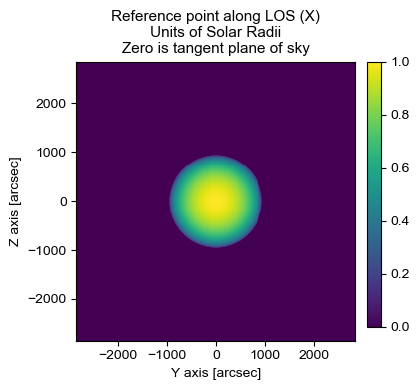

In [21]:
## First find the cartestian coordinates of a set of reference points for the lines of sight
## in the observer's geometry.  For offlimb points, this is the plane of the sky (yz). 
## On disk, these points should lie on the solar surface
xxObs = np.zeros_like(yya)
yyObs = rObs * np.tan(np.deg2rad(yya/3600.))
zzObs = rObs * np.tan(np.deg2rad(zza/3600.))
rrObs = np.sqrt(yyObs**2 + zzObs**2)
xxObs[rrObs<1] = np.sqrt(1 - rrObs[rrObs<1]**2)   ## puts the reference point on the surface 

fig = plt.figure(figsize = (5,4))
ax = plt.gca()
ax.pcolormesh(yarc,zarc,xxObs)
ax.set_aspect(1)
ax.set_xlabel("Y axis [arcsec]")
ax.set_ylabel("Z axis [arcsec]")
ax.set_title('Reference point along LOS (X)\nUnits of Solar Radii\nZero is tangent plane of sky',fontsize =11)

axi = ax
cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
cbar1 = fig.colorbar(axi.collections[0],ax=axi,cax=cax)  # axi.get_images()[0],ax=axi,cax=cax)

fig.tight_layout()

In [22]:
## rotate these points into the model geometry with Euler rotation
## OLD VERSION [WRONG]: rotm = euler_ry((thetaObs-np.pi/2.)) @ euler_rz(phiObs)
## corrected matrix ?  rotate from LOS into PSI frame, by first rotating in theta and then phi 
rotm = euler_rz(phiObs) @ euler_ry((thetaObs-np.pi/2.)) 
## earlier I had the rotation matrix as the transpose...not sure why..incorrect?
xyz_model = rotm  @ np.stack((xxObs.flatten(),yyObs.flatten(),zzObs.flatten())) 

## NOW WITH THE XYZ_MODEL POINTS AND THE LOCATION OF THE OBSERVER IN MODEL FRAME
## come up with the parametric equations for the los of sight
losvec    = np.stack((xObs-xyz_model[0,:],yObs-xyz_model[1,:],zObs - xyz_model[2,:]))
losveclen = np.linalg.norm(losvec,axis=0,ord=2,keepdims = True)
losvec    = losvec / losveclen
startpt   = xyz_model

In [23]:
## determine sampling width along the line of sight 
phis,thetas,rs = corona.phis,corona.thetas,corona.rs
deltaR = (np.roll(rs,-1) - rs)[:(-1)]    ## using the radial sampling of the PSI model as the step size for the integration
deltaR = np.cumsum(deltaR)
deltaR = np.hstack((-np.flip(deltaR),deltaR))  ## both directions

In [24]:
rays_xyz = startpt[None,:,:] + (losvec * deltaR[:,None,None])
rays_xyz = np.swapaxes(rays_xyz,1,2)
print(rays_xyz.shape)

(298, 81225, 3)


In [25]:
nrays   = startpt.shape[1]
ray_npt = len(deltaR)
print('Number of rays to trace: ',nrays) 
print('Max number of samples per ray: ',ray_npt)

Number of rays to trace:  81225
Max number of samples per ray:  298


In [26]:
## get spherical coordinates of rays
rays_sph = np.zeros_like(rays_xyz)
rays_sph[:,:,0] = np.linalg.norm(rays_xyz,axis=2)        ## l2-norm 
rays_sph[:,:,1] = np.arccos(rays_xyz[:,:,2] / rays_sph[:,:,0])   ## arccos (z / r) 
rays_sph[:,:,2] = np.arctan2(rays_xyz[:,:,1] , rays_xyz[:,:,0])   ## arctan (y / x) 
rays_sph[:,:,2][rays_sph[:,:,2] <0] += 2.*np.pi ## so that it falls in the simulation domain 

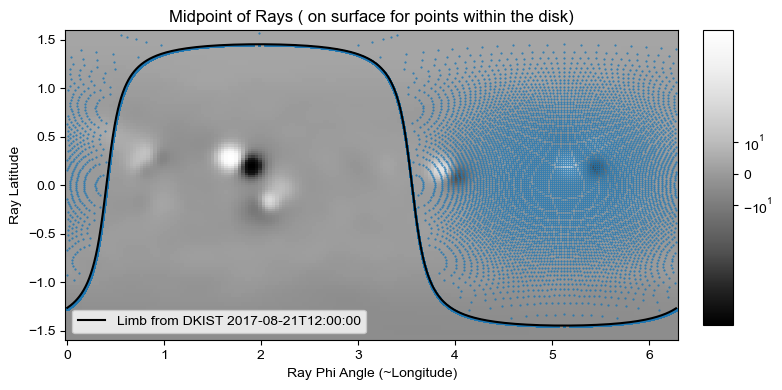

In [27]:
fig = plt.figure(figsize = (8,4))
ax = fig.gca(),
kk = 35
ax[0].pcolormesh(corona.lons,corona.lats,corona.br[:,:,kk].T,cmap = 'Greys_r',norm = SymLogNorm(40))
ax[0].set_aspect(1)
ax[0].plot(rays_sph[ray_npt//2,:,2],np.pi/2. - rays_sph[ray_npt//2,:,1],'.',markersize = 1)
ax[0].set_ylabel("Ray Latitude")
ax[0].set_title("Midpoint of Rays ( on surface for points within the disk)")
ax[0].set_xlabel("Ray Phi Angle (~Longitude)")
for axi in ax: 
    axi.plot(latlon[1,:],latlon[0,:],'-',color = 'black',label = f'Limb from DKIST {observerDKIST.obstime.isot[0:19]}')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.collections[0],ax=axi,cax=cax)  # axi.get_images()[0],ax=axi,cax=cax)
axi.legend()
fig.tight_layout()

In [28]:
print(startpt.shape,rays_sph.shape,rays_xyz.shape)
print(np.max(deltaR))

(3, 81225) (298, 81225, 3) (298, 81225, 3)
29.0


In [29]:
if 0: 
    print(rays_sph.shape)
    plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(rays_xyz[0,::10,0],rays_xyz[0,::10,1],rays_xyz[0,::10,2])
    ax.scatter3D(rays_xyz[ray_npt//2,::10,0],rays_xyz[ray_npt//2,::10,1],rays_xyz[ray_npt//2,::10,2])
    ax.scatter3D(rays_xyz[-1,::10,0],rays_xyz[-1,::10,1],rays_xyz[-1,::10,2])

    ax.scatter3D(xObs,yObs,zObs,'x',color = 'black') ## cartesian position of Observer in PSI model geometery (units of solar radii)
    ax.plot3D([0,xObs],[0,yObs],[0,zObs],ls = 'dashdot',color  = 'black')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5)
    ax.set_zlim(-5,5)

    plt.figure(figsize = (6,4))
    plt.scatter(rays_xyz[ray_npt//2,:,2], rays_xyz[ray_npt//2,:,1],c=rays_sph[ray_npt//2,:,0],s=0.5)  ## lons, lats
    plt.ylim(-1,1)

## Interpolate model variables at ray samples

In [30]:
rays_xyz = rays_xyz.reshape(ray_npt*nrays,3)
rays_sph = rays_sph.reshape(ray_npt*nrays,3)

In [31]:
#### Get interpolating functions for all necessary simulation data
#### the ccoefInt already has the density factors included
ccoef1Int = rgi((phis,thetas,rs),ccoef_10747,method = 'linear',fill_value = 0.,bounds_error = False)
align1Int = rgi((phis,thetas,rs),align_10747,method = 'linear',fill_value = 0.,bounds_error = False)
bxInt    = rgi((phis,thetas,rs),corona.bx,method = 'linear',fill_value = 0.,bounds_error = False)
byInt    = rgi((phis,thetas,rs),corona.by,method = 'linear',fill_value = 0.,bounds_error = False)
bzInt    = rgi((phis,thetas,rs),corona.bz,method = 'linear',fill_value = 0.,bounds_error = False)
tempInt  = rgi((phis,thetas,rs),corona.temp,method = 'linear',fill_value = 0.,bounds_error = False)
neInt    = rgi((phis,thetas,rs),corona.ne,method = 'linear',fill_value = 0.,bounds_error = False)

In [32]:
def parallel_int(argin):
    iobj,i0,i1 = argin
    return iobj(rays_sph[i0:i1,::-1])
        
def interpolate_raypts(iobj_int): 
                       
    nproc = 20
    nptint = ray_npt*nrays
    nrays_per_proc = np.ceil(nptint/nproc).astype(int)
    args = []
    for n in range(nproc):
        i0,i1 = n*nrays_per_proc,  (n+1)*nrays_per_proc
        i1 = np.clip(i1,0,nptint)
        args.append((iobj_int,i0,i1))
    
    p =  multiprocessing.Pool(processes=nproc,maxtasksperchild = 1000) 
    rs = p.imap(parallel_int,args)
    p.close()
    
    var_rays = np.zeros(nptint)
    
    nargs = len(args)
    pbar = tqdm.tqdm(total=nargs, position=0, leave=True)
    for i,res in enumerate(rs):
        i0,i1 = args[i][1:]
        var_rays[i0:i1] = res 
        pbar.update()
    pbar.close()

    return var_rays

In [33]:
## get bx,by,bz in PSI geometry for all the ray points
## this is the step that takes the longest! 
bx_rays = interpolate_raypts(bxInt)
by_rays = interpolate_raypts(byInt)
bz_rays = interpolate_raypts(bzInt)
temp_rays = interpolate_raypts(tempInt)
ne_rays = interpolate_raypts(neInt)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.24it/s]


In [34]:
ccoef1_rays = interpolate_raypts(ccoef1Int) 
align1_rays = interpolate_raypts(align1Int) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.36it/s]


In [35]:
ccoef1_rays = ccoef1_rays.reshape(ray_npt,nrays)
align1_rays = align1_rays.reshape(ray_npt,nrays)
temp_rays = temp_rays.reshape(ray_npt,nrays)
ne_rays = ne_rays.reshape(ray_npt,nrays)

In [36]:
rays_xyz = rays_xyz.reshape(ray_npt,nrays,3)
rays_sph = rays_sph.reshape(ray_npt,nrays,3)

In [37]:
## calculate the magnetic field inclination angle wrt the line-of-sight 
bxyzs = np.stack((bx_rays,by_rays,bz_rays)).T
blens = np.linalg.norm(bxyzs,axis =1)
bxyzs = bxyzs.reshape(ray_npt,nrays,3)
blens = blens.reshape(ray_npt,nrays)
thetaBlos = np.arccos( (np.sum(bxyzs*losvec.T[None,:,:],axis=2)/blens).clip(min = -1,max=1))
thetaBlos[np.isnan(thetaBlos)] = 0.

/tmp/ipykernel_1139256/3178097367.py:6: RuntimeWarning: invalid value encountered in divide
  thetaBlos = np.arccos( (np.sum(bxyzs*losvec.T[None,:,:],axis=2)/blens).clip(min = -1,max=1))


In [38]:
## angle between losvec and the vector from disk center
thetaDClos = np.arccos( (np.sum(rays_xyz*losvec.T[None,:,:],axis=2)/rays_sph[:,:,0]).clip(min = -1,max=1))

In [39]:
## get projection of B onto plane perpendicular to LOS
## and the projection of DC vector onto same plane
Bperp  = bxyzs - (blens*np.cos(thetaBlos))[:,:,None] * losvec.T[None,:,:]
DCperp = rays_xyz - (rays_sph[:,:,0]*np.cos(thetaDClos))[:,:,None] * losvec.T[None,:,:]

In [40]:
## find angle between Bperp and DCperp, which is the azimuthal angle relative to disk center
costhetaAzi = np.sum((Bperp*DCperp),axis=2)/(np.linalg.norm(Bperp,axis = 2)*np.linalg.norm(DCperp,axis = 2))
del Bperp
del DCperp
thetaAzi = np.arccos(costhetaAzi.clip(min =-1,max=1))
thetaAzi[np.isnan(thetaAzi)] = 0.
del costhetaAzi

/tmp/ipykernel_1139256/3888707345.py:2: RuntimeWarning: invalid value encountered in divide
  costhetaAzi = np.sum((Bperp*DCperp),axis=2)/(np.linalg.norm(Bperp,axis = 2)*np.linalg.norm(DCperp,axis = 2))


## Show maps of model variables in the Plane of the Sky from the Observers location 

- Note that here, the mid point on the disk will land on the photosphere nearest the Observer 

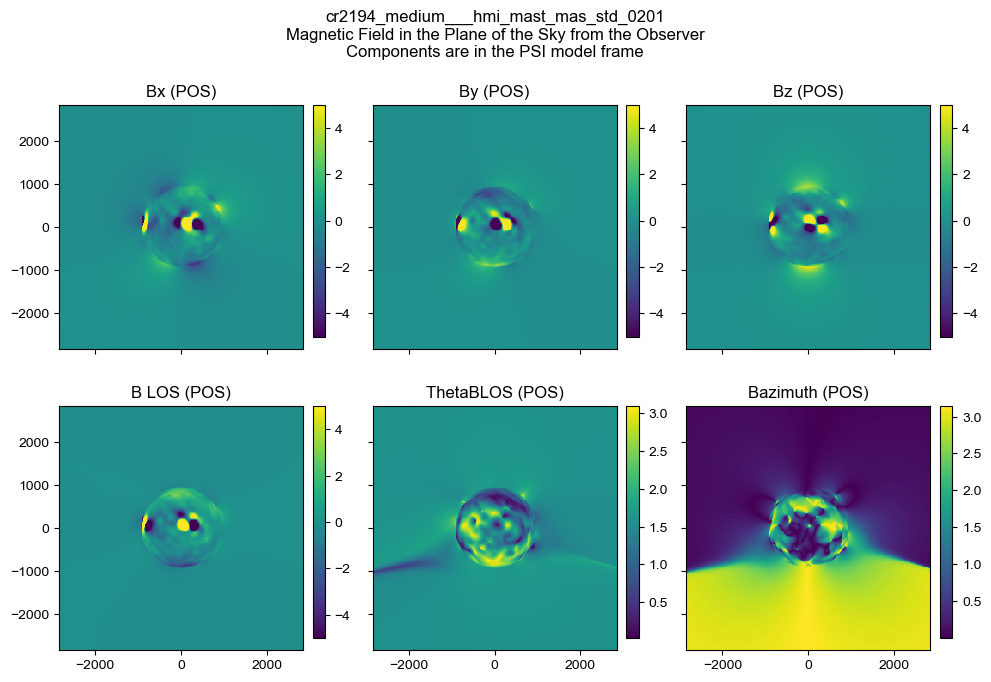

In [41]:
fig,ax = plt.subplots(2,3,figsize = (10,7),sharex=True,sharey=True)
ax = ax.flatten()
fov_extent = (yarc[0],yarc[-1],zarc[0],zarc[-1])
im0 = ax[0].imshow(bx_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape),extent = fov_extent)
im1 = ax[1].imshow(by_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape),extent = fov_extent)
im2 = ax[2].imshow(bz_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape),extent = fov_extent)

im3 = ax[3].imshow(blens[ray_npt//2,:].reshape(*yya.shape) * np.cos(thetaBlos[ray_npt//2,:].reshape(*yya.shape)),extent = fov_extent)
im4 = ax[4].imshow(thetaBlos[ray_npt//2,:].reshape(*yya.shape),extent = fov_extent)
im5 = ax[5].imshow(thetaAzi[ray_npt//2,:].reshape(*yya.shape),extent = fov_extent)
for imn in im0,im1,im2,:imn.set_clim(-5,5)
im3.set_clim(-5,5)

labs = 'Bx (POS)','By (POS)','Bz (POS)','B LOS (POS)','ThetaBLOS (POS)','Bazimuth (POS)'
for n in range(6): ax[n].set_title(labs[n])

cbars = []
for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)

fig.suptitle(modelName + '\nMagnetic Field in the Plane of the Sky from the Observer\nComponents are in the PSI model frame') 
fig.tight_layout()

1778279.410038923


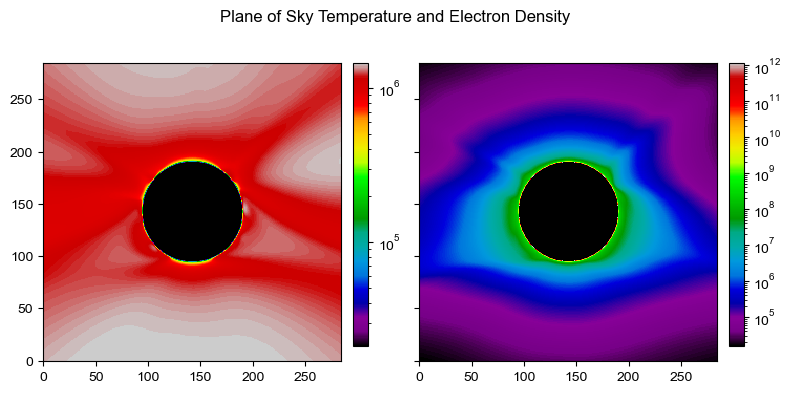

In [42]:
fig,ax = plt.subplots(1,2,figsize = (8,4),sharex=True,sharey=True)
ax = ax.flatten()
cm = plt.get_cmap('nipy_spectral')
cm.set_bad('black')
im0 = ax[0].imshow(temp_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk,norm = LogNorm(),cmap = cm)
im1 = ax[1].imshow(ne_rays.reshape(ray_npt,nrays)[ray_npt//2,:].reshape(*yya.shape)*mask_ondisk,norm = LogNorm(),cmap =cm)

print(10.**6.25)

cbars = []
for axi in ax:
 cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
 cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
 cbars.append(cbar1)

fig.suptitle('Plane of Sky Temperature and Electron Density')
fig.tight_layout()

## Forward Synthesize the Thomson Scattered K-Corona

In [43]:
## calculation heights in km 
ht = (rays_sph[:,:,0]-1).clip(1.e-8) * constants.radius.value/1000.
ht = ht.reshape(ray_npt*nrays)
## CENTER PASSBAND OF MLSO/COSMO/K-COR IS AT 7350 Angstrom 
## here using 10747 for CryoNIRSP Fe XIII Observations
J00,units = allen.J00_sym(10747.,ht)  ## Get the mean intensity value J00 at wavelength and height 
omega = allen.get_omega(10747.,ht)
print(f" Units of J00 are {units}")

 Units of J00 are erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ Hz$^{-1}$


In [44]:
Idc, Idc_unit = allen.i_nu(10747.,1.)
print(f" Disk Center Intensity at Center Wavelength is {Idc} {Idc_unit}")

 Disk Center Intensity at Center Wavelength is 4.134801755394727e-05 erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ Hz$^{-1}$


In [45]:
J00 = J00.reshape(ray_npt,nrays)
omega = omega.reshape(ray_npt,nrays)

In [46]:
## distance vector along the ray 
dray = deltaR[:,None] * constants.radius.value*100.  ## cm 
drayg = np.gradient(dray[:,0])

In [47]:
cc = 0.665e-24  ## total thomson scattering crosssection; units:: cm^2
## emission coefficients along line of sight (Equation 20 in Schad et al. 2022)
eps_rays = cc * ne_rays * J00 * (1 + omega/2 - (3./4.)*omega*np.sin(thetaDClos)**2)
Ithomson = np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape) * mask_ondisk / Idc *1e6  ## millionths of DC radiance 
eps_rays = - 3./4. * cc * ne_rays * omega * J00 * np.sin(thetaDClos)**2
pBthomson = np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape) * mask_ondisk / Idc *1e6 ## millionths of DC radiance 

/tmp/ipykernel_1139256/82308066.py:5: RuntimeWarning: invalid value encountered in divide
  im2 = ax[2].imshow(-pBthomson/Ithomson*mask_ondisk,cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)


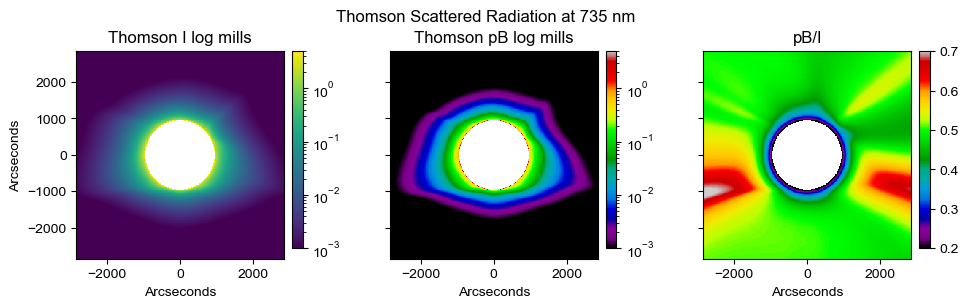

In [48]:
fig,ax = plt.subplots(1,3,figsize = (10,3.),sharey=True,sharex=True)
ax = ax.flatten()
im0 = ax[0].imshow(Ithomson*mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('viridis'),extent = fov_extent)
im1 = ax[1].imshow(-pBthomson*mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)
im2 = ax[2].imshow(-pBthomson/Ithomson*mask_ondisk,cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)
im0.set_clim(0.001,5)
im1.set_clim(0.001,5)
im2.set_clim(0.2,0.7)
ax[0].set_ylabel('Arcseconds')
cbars = []
for axi in ax:
    axi.set_xlabel('Arcseconds')
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)

ax[0].set_title('Thomson I log mills')
ax[1].set_title('Thomson pB log mills')
ax[2].set_title('pB/I')

fig.suptitle('Thomson Scattered Radiation at 735 nm')
fig.tight_layout(pad = 0.5)

## Get Temperate and Density weighted by the Thomson scattered total intensity

In [49]:
## weight temp and ne by thomson scattered signal? 
cc = 0.665e-24  ## total thomson scattering crosssection
eps_rays = cc * ne_rays * J00 * (1 + omega/2 - (3./4.)*omega*np.sin(thetaDClos)**2)
wgtTemp = np.trapz(temp_rays*eps_rays,dray,axis=0).reshape(*yya.shape) / np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape)
wgtNe  = np.trapz(ne_rays*eps_rays,dray,axis=0).reshape(*yya.shape) / np.trapz(eps_rays,dray,axis=0).reshape(*yya.shape)

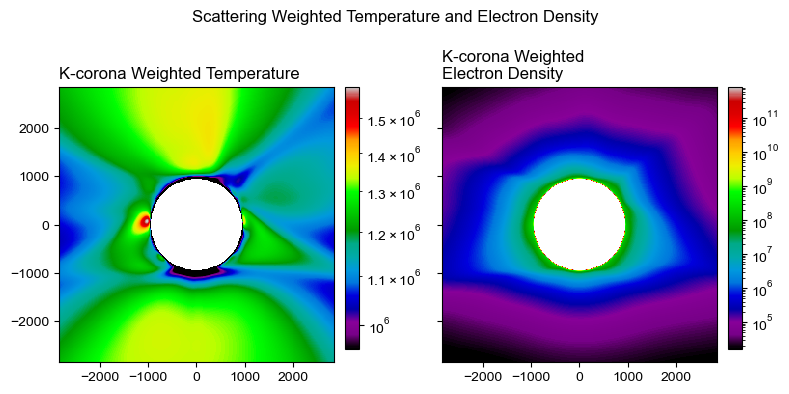

In [50]:
fig,ax = plt.subplots(1,2,figsize = (8,4),sharex=True,sharey=True)
ax = ax.flatten()

im0 = ax[0].imshow(wgtTemp.reshape(*yya.shape) * mask_ondisk,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)
im1 = ax[1].imshow(wgtNe.reshape(*yya.shape) * mask_ondisk,norm = LogNorm(), cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)

tmp = wgtTemp.reshape(*yya.shape)
tmp = tmp[mask_ondisk==1]
im0.set_clim(np.nanpercentile(tmp,[1,100]))
tmp = wgtNe.reshape(*yya.shape)
tmp = tmp[mask_ondisk==1]
im1.set_clim(np.nanpercentile(tmp,[1,100]))

cbars = []
for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)
ax[0].set_title("K-corona Weighted Temperature",loc = 'left')
ax[1].set_title("K-corona Weighted \nElectron Density",loc = 'left')
fig.suptitle('Scattering Weighted Temperature and Electron Density')
fig.tight_layout()

## Forward Synthesize the Emission Line (Here 1074 nm Fe XIII)

In [51]:
## distance vector along the ray 
dray = deltaR[:,None] * constants.radius.value*100.  ## cm 
drayg = np.gradient(dray[:,0])

Recall that in https://github.com/tschad/pycelp/blob/polEmiss_examples/pycelp/emissionLine.py

self.C_coeff =   self.hnu/4./np.pi * self.Einstein_A * self.upper_level_pop_frac * self.total_ion_population

See equation 3, 5,7,8 in Schad & Dima (2020) -- units of ergs /s / sr / cm^3  [?] 

In [52]:
geff,D_coeff,E_coeff = fe13_ln1.geff,fe13_ln1.Dcoeff,fe13_ln1.Ecoeff
cc = 2.99792458e10 ## cm s^-1 (speed of light)
wv_vac_cm = fe13_ln1.wavelength_in_vacuum * 1.e-8 
Vscl   = - (wv_vac_cm)**2 / cc * 1.e8 ## units of Angstrom *s 
epsI   = ccoef1_rays*(1.0+(1./(2.*np.sqrt(2.)))*(3.*np.cos(thetaBlos)**2 - 1.)*D_coeff*align1_rays)
epsQnr = ccoef1_rays*(3./(2.*np.sqrt(2.)))*(np.sin(thetaBlos)**2)*D_coeff*align1_rays
epsQ   = np.cos(2.*thetaAzi)*epsQnr
epsU   = -np.sin(2.*thetaAzi)*epsQnr
epsV   = Vscl* ccoef1_rays*np.cos(thetaBlos)*(1399612.2*blens)*(geff + E_coeff*align1_rays)
epsI_int1 = np.trapz(epsI,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsQ_int1 = np.trapz(epsQ,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsU_int1 = np.trapz(epsU,dray,axis=0).reshape(*yya.shape) * mask_ondisk
epsV_int1 = np.trapz(epsV,dray,axis=0).reshape(*yya.shape) * mask_ondisk
ne_wgtI1 = np.sum(epsI*ne_rays*drayg[:,None],axis=0)    ## volumetric weighted? 
ne_wgtI1 /= np.sum(epsI*drayg[:,None],axis=0)
ne_wgtI1 = ne_wgtI1.reshape(*yya.shape)*mask_ondisk

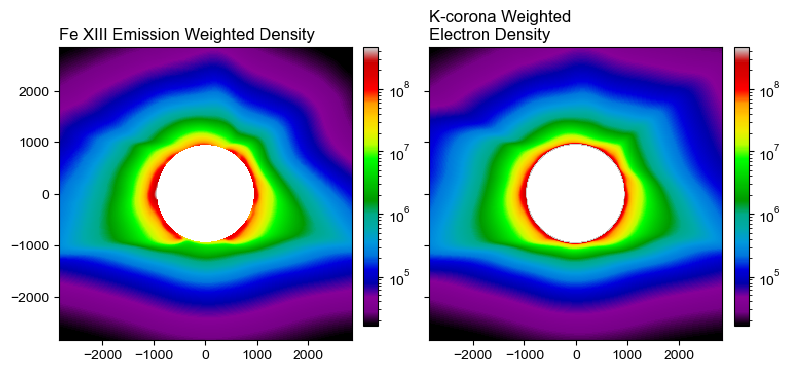

In [53]:
fig,ax = plt.subplots(1,2,figsize = (8,4),sharex=True,sharey=True)
ax = ax.flatten()

im0 = ax[0].imshow(ne_wgtI1,norm = LogNorm(),cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)
im1 = ax[1].imshow(wgtNe.reshape(*yya.shape) * mask_ondisk,norm = LogNorm(), cmap = plt.get_cmap('nipy_spectral'),extent = fov_extent)

tmp = ne_wgtI1
tmp = tmp[mask_ondisk==1]
im0.set_clim(np.nanpercentile(tmp,[1,100]))
im1.set_clim(np.nanpercentile(tmp,[1,100]))

cbars = []
for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)
ax[0].set_title("Fe XIII Emission Weighted Density",loc = 'left')
ax[1].set_title("K-corona Weighted \nElectron Density",loc = 'left')
fig.tight_layout()

In [54]:
Idc_lambda, Idc_lambda_unit = allen.i_lambda(10747,1.)
print(f" Disk Center Intensity at Center Wavelength is {Idc_lambda} {Idc_lambda_unit}")

 Disk Center Intensity at Center Wavelength is 1073250.0 erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ $\AA^{-1}$


In [55]:
sr2arcsec = (180./np.pi)**2.*3600.**2.
hh        = 6.6260755e-27                  ## erg s
phergs1    = hh*(3.e8)/(10747.0e-10)      ## ergs to photons
epsI_int_photons = epsI_int1/sr2arcsec/phergs1 

In [56]:
fwhm_median_1074 = 1.58  ## Angstrom  [Schad et al. 2023] 
sig = fwhm_median_1074 / (2.*np.sqrt(2.*np.log(2)))
int_mills = epsI_int1 * (1./(np.sqrt(2.*np.pi)*sig)) / Idc_lambda *1e6

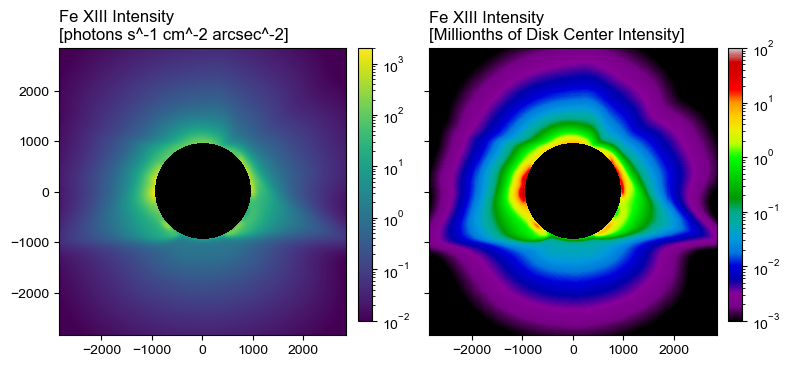

In [57]:
##  Show intensity in photon units and in millionths (assuming some line width) 

fig,ax = plt.subplots(1,2,figsize = (8,4),sharex=True,sharey=True) 
ax = ax.flatten()

cm = plt.get_cmap('viridis').copy()
cm.set_bad('k')

im0 = ax[0].imshow(epsI_int_photons,norm = LogNorm(),cmap = cm,extent = fov_extent)
im0.set_clim(0.01,2000.)

cm = plt.get_cmap('nipy_spectral').copy()
cm.set_bad('k')
im1 = ax[1].imshow(int_mills,norm = LogNorm(),cmap = cm,extent = fov_extent)
im1.set_clim(0.001,100.)

cbars = []
for axi in ax:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)

ax[0].set_title("Fe XIII Intensity\n[photons s^-1 cm^-2 arcsec^-2]",loc = 'left')
ax[1].set_title("Fe XIII Intensity\n[Millionths of Disk Center Intensity]",loc = 'left')
fig.tight_layout()

/tmp/ipykernel_1139256/1927896013.py:5: RuntimeWarning: invalid value encountered in divide
  im2 = ax[2].imshow(np.sqrt(epsQ_int1**2. + epsU_int1**2)/epsI_int1,norm = LogNorm(),extent = fov_extent)


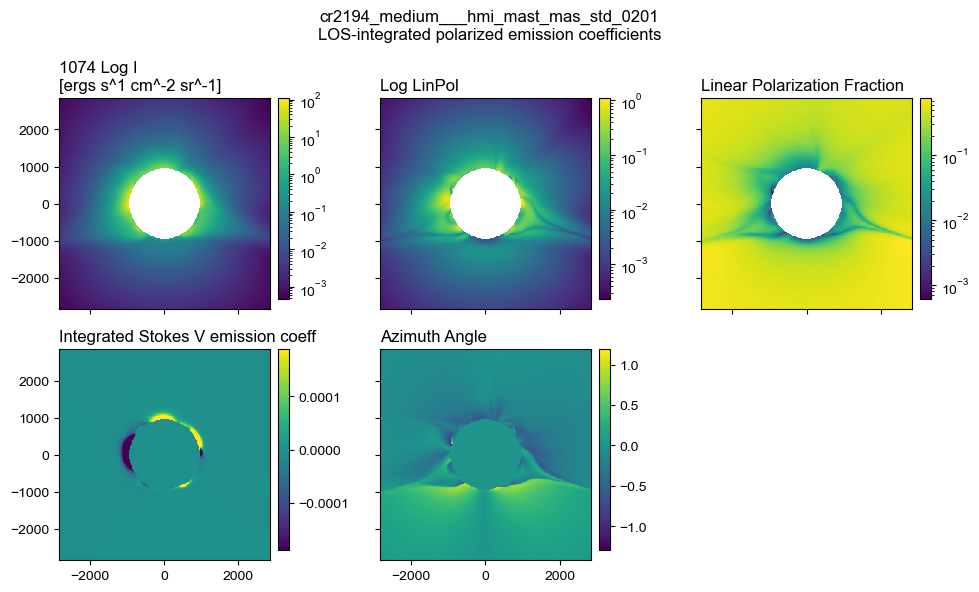

In [58]:
fig,ax = plt.subplots(2,3,figsize = (10,6),sharex=True,sharey=True)
ax = ax.flatten()
im0 = ax[0].imshow(epsI_int1,norm = LogNorm(),extent = fov_extent)
im1 = ax[1].imshow(np.sqrt(epsQ_int1**2. + epsU_int1**2),norm = LogNorm(),extent = fov_extent)
im2 = ax[2].imshow(np.sqrt(epsQ_int1**2. + epsU_int1**2)/epsI_int1,norm = LogNorm(),extent = fov_extent)
im3 = ax[3].imshow(epsV_int1,extent = fov_extent)
mrang = np.max(np.abs(np.percentile(epsV_int1,[0.5,99.])))
im3.set_clim(-mrang,mrang)

im4 = ax[4].imshow(0.5*np.arctan2(epsU_int1 , epsQ_int1)*mask_ondisk,extent = fov_extent)

labs = '1074 Log I\n[ergs s^1 cm^-2 sr^-1]','Log LinPol','Linear Polarization Fraction','Integrated Stokes V emission coeff','Azimuth Angle'
for n in range(5): ax[n].set_title(labs[n],loc = 'left')

ax[-1].axis('off')

cbars = []
for axi in ax[:-1]:
    cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
    cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
    cbars.append(cbar1)

fig.suptitle(modelName + '\nLOS-integrated polarized emission coefficients') 

fig.tight_layout()

## Stokes Spectra Generation for 1074

In [59]:
geff,D_coeff,E_coeff = fe13_ln1.geff,fe13_ln1.Dcoeff,fe13_ln1.Ecoeff
cc = 2.99792458e10 ## cm s^-1 (speed of light)
wv_vac_cm = fe13_ln1.wavelength_in_vacuum * 1.e-8 
Vscl   = - (wv_vac_cm)**2 / cc * 1.e8 ## units of Angstrom *s 
epsI   = ccoef1_rays*(1.0+(1./(2.*np.sqrt(2.)))*(3.*np.cos(thetaBlos)**2 - 1.)*D_coeff*align1_rays)
epsQnr = ccoef1_rays*(3./(2.*np.sqrt(2.)))*(np.sin(thetaBlos)**2)*D_coeff*align1_rays
epsQ   = np.cos(2.*thetaAzi)*epsQnr
epsU   = -np.sin(2.*thetaAzi)*epsQnr
epsV   = Vscl* ccoef1_rays*np.cos(thetaBlos)*(1399612.2*blens)*(geff + E_coeff*align1_rays)

In [60]:
epsV.shape

(298, 81225)

In [61]:
epsV_re = epsV.reshape(epsV.shape[0],*yya.shape)
epsV_re.shape

(298, 285, 285)

In [62]:
ht = (rays_sph[:,:,0]-1).clip(1.e-8)
ht.shape

(298, 81225)

In [63]:
## convert emission coefficients to photons /s /arcsec2 / cm2 units 
sr2arcsec = (180./np.pi)**2.*3600.**2.
hh = 6.626176e-27  ## ergs sec (planck's constant);
phergs = hh*(3.e8)/(fe13_ln1.wavelength_in_vacuum * 1.e-10)

epsI = epsI/sr2arcsec/phergs        
epsQ = epsQ/sr2arcsec/phergs        
epsU = epsU/sr2arcsec/phergs        
epsV = epsV/sr2arcsec/phergs        

In [64]:
doppler_velocity = 0.
non_thermal_turb_velocity = 0.
doppler_spectral_range = (-120,120)
specRes_wv_over_dwv = 100000

dVel = 3e5 / specRes_wv_over_dwv
nwv = np.ceil((doppler_spectral_range[1] - doppler_spectral_range[0]) / dVel).astype(int)
velvec = np.linspace(*doppler_spectral_range,nwv)  ##;; velocity range used for the spectral axis
wvvec = (fe13_ln1.wavelength_in_air  *1.e-10)*(1. + velvec/3.e5)  ## in units of meters at this point 

In [65]:
awgt = fe13_ln1.atomic_weight
M = (awgt*1.6605655e-24)/1000.   ## kilogram
kb = 1.380648e-23  ## J K^-1 [ = kg m^2 s^-2 K^-1]
etemp = temp_rays
turbv = non_thermal_turb_velocity
sig = (1./np.sqrt(2.))*(fe13_ln1.wavelength_in_air*1.e-10/3.e8)*np.sqrt(2.*kb*etemp/M + (turbv*1000.)**2.)

In [66]:
## calculate line center position 
wv0 = (fe13_ln1.wavelength_in_air*1.e-10) + (doppler_velocity/3.e5)*(fe13_ln1.wavelength_in_air*1.e-10)    ## in meters 
wv0 = wv0*1.e10     ## convert to Angstrom 
sig = sig*1.e10      ## convert to Angstrom 
wvvec = wvvec*1.e10  ## convert to Angstrom 

## Single Ray Spectrum Synthesis as an Example

In [67]:
%%time 
iray = 10487
wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
wprof_deriv_iray =  (- (wvvec[:,None]-wv0) / sig[:,iray][None,:]**2)  * wprof_iray 

stokes = np.zeros((len(wvvec),4))
stokes[:,0] = np.trapz(epsI[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
stokes[:,1] = np.trapz(epsQ[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
stokes[:,2] = np.trapz(epsU[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
stokes[:,3] = np.trapz(epsV[:,iray][None,:] * wprof_deriv_iray,dray[:,0],axis=1)

CPU times: user 0 ns, sys: 1.5 ms, total: 1.5 ms
Wall time: 1.21 ms


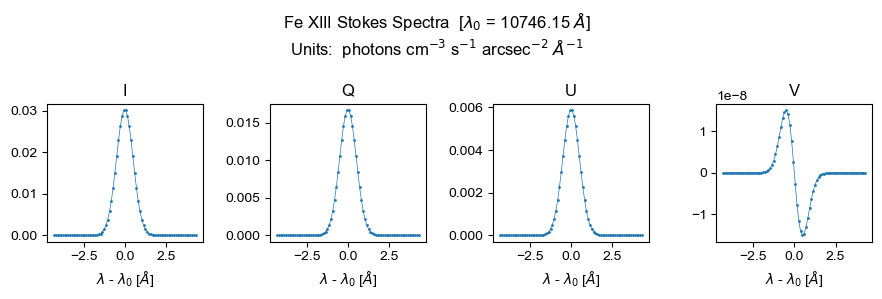

In [68]:
fig,ax = plt.subplots(1,4,figsize = (9,3),sharex=True)
ax = ax.flatten()
labels = 'I','Q','U','V'
for n in range(4): 
    ax[n].plot(wvvec -fe13_ln1.wavelength_in_air,stokes[:,n],'.-',lw = 0.5,markersize = 2)
    ax[n].set_title(labels[n])
    ax[n].set_xlabel(r'$\lambda$ - $\lambda_0$ [$\AA$]')
fig.suptitle('Fe XIII Stokes Spectra  [' + r'$\lambda_0$ = ' + str(np.round(fe13_ln1.wavelength_in_air,2)) + r' $\AA$' + ']\n' + 
             r'Units:  photons cm$^{-3}$ s$^{-1}$ arcsec$^{-2}$ $\AA^{-1}$')
fig.tight_layout()

## Generate stokes spectra for full map

In [69]:
stokes = np.zeros((nrays,len(wvvec),4))

for iray in trange(nrays): 
    wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
    wprof_deriv_iray =  (- (wvvec[:,None]-wv0) / sig[:,iray][None,:]**2)  * wprof_iray 
    
    stokes[iray,:,0] = np.trapz(epsI[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
    stokes[iray,:,1] = np.trapz(epsQ[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
    stokes[iray,:,2] = np.trapz(epsU[:,iray][None,:] * wprof_iray,dray[:,0],axis=1)
    stokes[iray,:,3] = np.trapz(epsV[:,iray][None,:] * wprof_deriv_iray,dray[:,0],axis=1)

  0%|          | 0/81225 [00:00<?, ?it/s]

/tmp/ipykernel_1139256/1767541552.py:4: RuntimeWarning: divide by zero encountered in divide
  wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
/tmp/ipykernel_1139256/1767541552.py:4: RuntimeWarning: invalid value encountered in multiply
  wprof_iray = (1./(np.sqrt(2.*np.pi)*sig[:,iray])) * np.exp(-(wvvec[:,None]-wv0)**2./(2.*sig[:,iray][None,:]**2.))
/tmp/ipykernel_1139256/1767541552.py:5: RuntimeWarning: divide by zero encountered in divide
  wprof_deriv_iray =  (- (wvvec[:,None]-wv0) / sig[:,iray][None,:]**2)  * wprof_iray


In [70]:
stokes.shape

(81225, 80, 4)

In [71]:
Idc, Idc_unit = allen.i_lambda(10747.,1.)
print(Idc,Idc_unit)
Idc_ph = Idc/sr2arcsec/phergs
print(Idc/sr2arcsec/phergs)

1073250.0 erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ $\AA^{-1}$
13640764.768267948


In [72]:
stokes.shape

(81225, 80, 4)

In [73]:
## Get a max signed Stokes V Map in the red wing of the line 
mp = np.max(stokes[:,40:,3],axis=1)
mn = np.max(-stokes[:,40:,3],axis=1)
mm = np.zeros_like(mp)
mm[mp>mn] = mp[mp>mn]
mm[mn>=mp] = -mn[mn>=mp]

Text(0.5, 1.0, 'Max Stokes V in millionths')

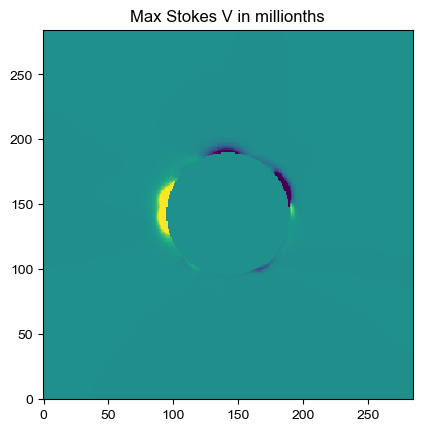

In [74]:
plt.figure()
plt.imshow(mm.reshape(*yya.shape) * mask_ondisk / Idc_ph*1e6)
plt.clim(-0.0005,0.0005)
plt.title('Max Stokes V in millionths')

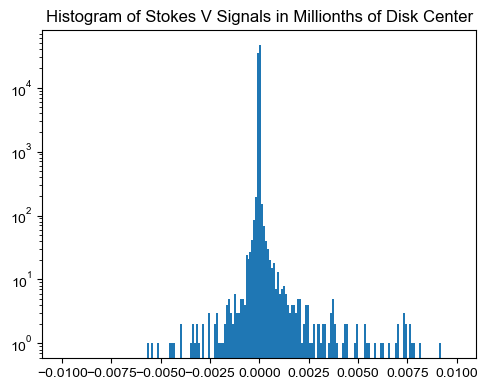

In [75]:
plt.figure(figsize = (5,4))
hh = plt.hist((mm.reshape(*yya.shape) * mask_ondisk / Idc_ph*1e6).flatten(),range=(-0.01,0.01),bins = 200)
plt.yscale('log')
plt.title("Histogram of Stokes V Signals in Millionths of Disk Center")
plt.tight_layout()

## Derive a LOS V "magnetogram"


In [76]:
stokes.shape

(81225, 80, 4)

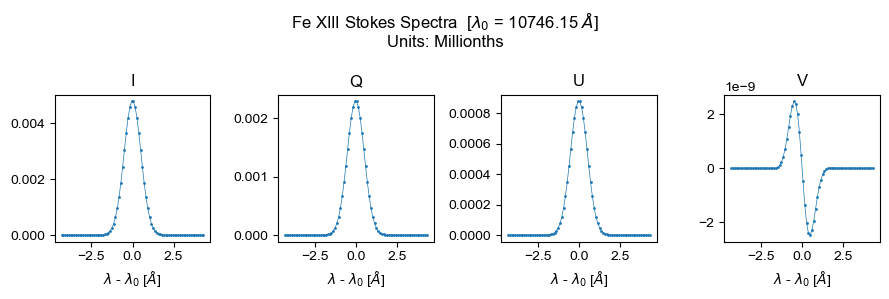

In [77]:
fig,ax = plt.subplots(1,4,figsize = (9,3),sharex=True)
ax = ax.flatten()
labels = 'I','Q','U','V'
iray= np.ravel_multi_index([40,90],yya.shape)
for n in range(4): 
    ax[n].plot(wvvec -fe13_ln1.wavelength_in_air,stokes[iray,:,n] / Idc_ph *1e6,'.-',lw = 0.5,markersize = 2)
    ax[n].set_title(labels[n])
    ax[n].set_xlabel(r'$\lambda$ - $\lambda_0$ [$\AA$]')
fig.suptitle('Fe XIII Stokes Spectra  [' + r'$\lambda_0$ = ' + str(np.round(fe13_ln1.wavelength_in_air,2)) + r' $\AA$' + ']\n' + 
             r'Units: Millionths')
fig.tight_layout()

### Weak field approximation

In [78]:
## sample ray 
iray= np.ravel_multi_index([40,90],yya.shape)

In [79]:
Vf_over_blos = - 4.6686e-10 * (wvvec.mean()**2) /1000. * fe13_ln1.geff *  np.gradient(stokes[iray,:,0],wvvec)  

Fitting LOS Magnetic Field [Gauss]: -0.00541305966253443


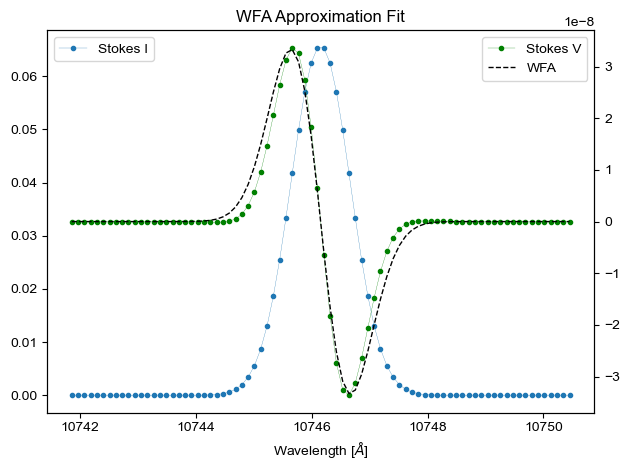

In [80]:
plt.figure()
plt.plot(wvvec,stokes[iray,:,0],'.-',label = 'Stokes I',lw = 0.2)
plt.xlabel(r"Wavelength [$\AA$]")
plt.legend(loc = 'upper left')

plt.twinx()
plt.plot(wvvec,stokes[iray,:,3],'g.-',label = 'Stokes V',lw = 0.2)
blos_fit = np.sum(stokes[iray,:,3]/Vf_over_blos * stokes[iray,:,0]) / np.sum(stokes[iray,:,0]) 
print(f"Fitting LOS Magnetic Field [Gauss]: {blos_fit}")
plt.plot(wvvec,Vf_over_blos * blos_fit,color = 'black',lw = 1,ls = 'dashed',label = 'WFA')
plt.title('WFA Approximation Fit')
plt.legend(loc = 'upper right')
plt.tight_layout()


In [81]:
blos_inf = np.zeros(nrays)
for iray in trange(nrays): 
    Vf_over_blos = - 4.6686e-10 * (wvvec.mean()**2) /1000. * fe13_ln1.geff *  np.gradient(stokes[iray,:,0],wvvec)  
    blos_inf[iray] = np.sum(stokes[iray,:,3]/Vf_over_blos * stokes[iray,:,0]) / np.sum(stokes[iray,:,0]) 

  0%|          | 0/81225 [00:00<?, ?it/s]

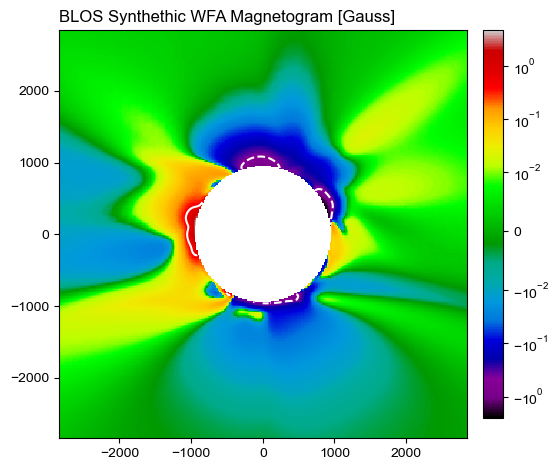

In [82]:
fig,axi = plt.subplots(1,1)
axi.imshow(blos_inf.reshape(*yya.shape),cmap = 'nipy_spectral',norm = SymLogNorm(0.01),extent = fov_extent)
axi.contour(blos_inf.reshape(*yya.shape),[-0.5,0.5],colors = 'white',extent = fov_extent)
cax = axi.inset_axes([1.04, 0.05, 0.05, 0.95], transform=axi.transAxes)
cbar1 = fig.colorbar(axi.get_images()[0],ax=axi,cax=cax)
axi.set_title('BLOS Synthethic WFA Magnetogram [Gauss]',loc = 'left')
fig.tight_layout()